In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import pickle
import json
import warnings
import datetime
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
% matplotlib inline

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
#load pickles
model = pickle.load(open('random_forest_p', 'rb'))
arima_parameters = json.load(open('arima_parameters.json', 'r'))

In [4]:
ar_param = arima_parameters['ar']
std_innovations = arima_parameters['std']

In [5]:
def get_clean_data(df_original):
    weekday_dict = {
        0:'Wd', 1:'Wd', 2:'Wd', 3:'Wd', 4:'Wd', 5:'F', 6:'F' 
    }
    
    df = df_original.copy(deep=True)
    df['date'] =  pd.to_datetime(df['datetime'].apply(lambda x: x[:10]), format='%Y-%m-%d')
    df['year'] = df['date'].dt.year
    df['time'] = pd.to_datetime(df['datetime'].apply(lambda x: x[:19])).dt.time
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['datetime'].apply(lambda x: x[11:13]).astype(int)
    df['minute'] = df['datetime'].apply(lambda x: x[14:16]).astype(int)
    df['weekday'] = df['date'].dt.dayofweek
    df.replace({'weekday':weekday_dict}, inplace=True)
    df['season'] = np.where(df['month'].isin(list(range(4,10))), 'summer', 'winter')
    df['date_hour'] = df.apply(lambda x: datetime.datetime.combine(x['date'], x['time']), axis=1)
    df.set_index('date_hour', inplace=True)
    clean_df = df[['date', 'year', 'month', 'season', 'day','weekday','time', 'hour', 'minute', 'value']]
    clean_df = clean_df[~clean_df.index.duplicated()]
    clean_df['hour'] = np.where(clean_df['hour'].isin(np.arange(9,23)), 'Peak', 'off_peak')
    #clean_df['value'] = np.log1p(clean_df['value'])
    clean_df_freq = clean_df.asfreq('H')
    
    return clean_df_freq

### Import data from 2017

In [6]:
raw_band_price = pd.read_csv('2017_data/export_PrecioBandaDeRegulaciónSecundaria_2017-02-13_21-01.csv',
                             encoding='latin1', delimiter=';')
band_price = get_clean_data(raw_band_price)
band_price = band_price.rename(columns={'value':'band'})

In [7]:
raw_spot_price = pd.read_csv('2017_data/export_PrecioMercadoSPOTDiarioEspaña_2017-02-13_20-59.csv',
                             encoding='latin1', delimiter=';')
spot_price = get_clean_data(raw_spot_price)
spot_price = spot_price.rename(columns={'value':'spot'})

In [8]:
raw_demand = pd.read_csv('2017_data/export_DemandaProgramada_2017-02-13_20-58.csv',
                         encoding='latin1', delimiter=';')
demand = get_clean_data(raw_demand)
demand = demand.rename(columns={'value':'demand'})

In [9]:
spot_band_demand = band_price.merge(spot_price[['spot']], how='left', left_index=True, right_index=True)
spot_band_demand = spot_band_demand.merge(demand[['demand']], how='left', left_index=True, right_index=True)

In [10]:
spot_band_demand = spot_band_demand[['hour', 'weekday', 'season', 'spot','demand', 'band']]

In [11]:
for feature in ['hour', 'weekday', 'season']:
    spot_band_demand[pd.get_dummies(spot_band_demand[feature], drop_first=True).columns.tolist()] = pd.get_dummies(spot_band_demand[feature], drop_first=True)

In [12]:
for feature in ['demand', 'spot']:
    spot_band_demand[feature + '-1'] = spot_band_demand[feature].shift(periods=+1)
    spot_band_demand[feature + '-24'] = spot_band_demand[feature].shift(periods=+24)
spot_band_demand['band-24'] = spot_band_demand['band'].shift(periods=24)
spot_band_demand.dropna(subset=['demand-1', 'spot-1', 'demand-24', 'spot-24', 'band-24'], inplace=True)

In [13]:
#Add winter since all values in season feature are winter
spot_band_demand['winter'] =1

### Check predictions for 2017

In [14]:
X = spot_band_demand[['spot','demand', 'off_peak', 'Wd', 
                     'winter', 'demand-1', 'demand-24', 
                     'spot-1', 'spot-24', 'band-24']].values
Y = spot_band_demand['band'].values

In [15]:
y_pred = model.predict(X)

In [16]:
print('MAE: %.4f, MSE: %.4f' %(mean_absolute_error(Y, y_pred), mean_squared_error(Y, y_pred)))

MAE: 6.0118, MSE: 71.8618


In [17]:
z_df = pd.DataFrame(data=y_pred, index=spot_band_demand.index, columns=['y_pred'])

In [18]:
z_df['y_true'] = Y

In [19]:
z_df['error'] = z_df['y_true'] - z_df['y_pred']

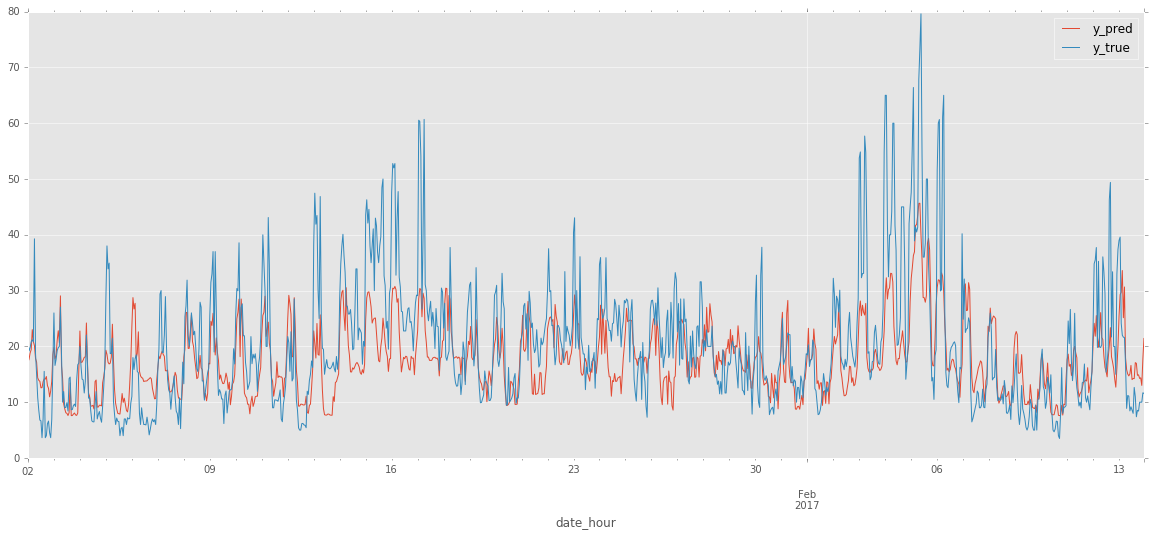

In [20]:
z_df[['y_pred', 'y_true']].plot(figsize=(20,8));

### Adding AR effect
$$S_{t} = f(X_{t})e^{Z_{t}} \\$$

$$Z_{t} = \alpha_{1} \cdot Z_{t-1}  + \alpha_{2} \cdot Z_{t-2} + \alpha_{3} \cdot Z_{t-3} + \epsilon _{t}$$

$$S_{t} = f(x)e^{(\alpha_{1} \cdot Z_{t-1}  + \alpha_{2} \cdot Z_{t-2} + \alpha_{3} \cdot Z_{t-3} +\epsilon _{t})}$$

##### One example without white noise

In [21]:
f_x = model.predict(X)

In [22]:
all_zt = (np.log1p(Y) - np.log1p(f_x))

In [32]:
rf_arima_df = pd.DataFrame(data={'f(x)':f_x,'zt_true':all_zt, 'S':Y}, index=spot_band_demand.index)

In [33]:
for i in [0,1,2]:
    rf_arima_df['zt-'+str(i+1)] = rf_arima_df['zt_true'].shift(i+1) * ar_param[i]
rf_arima_df['zt_pred'] = rf_arima_df.iloc[:,-3:].sum(axis=1)

In [35]:
rf_arima_df['S_pred'] = rf_arima_df['f(x)'] * np.exp(rf_arima_df['zt_pred'])

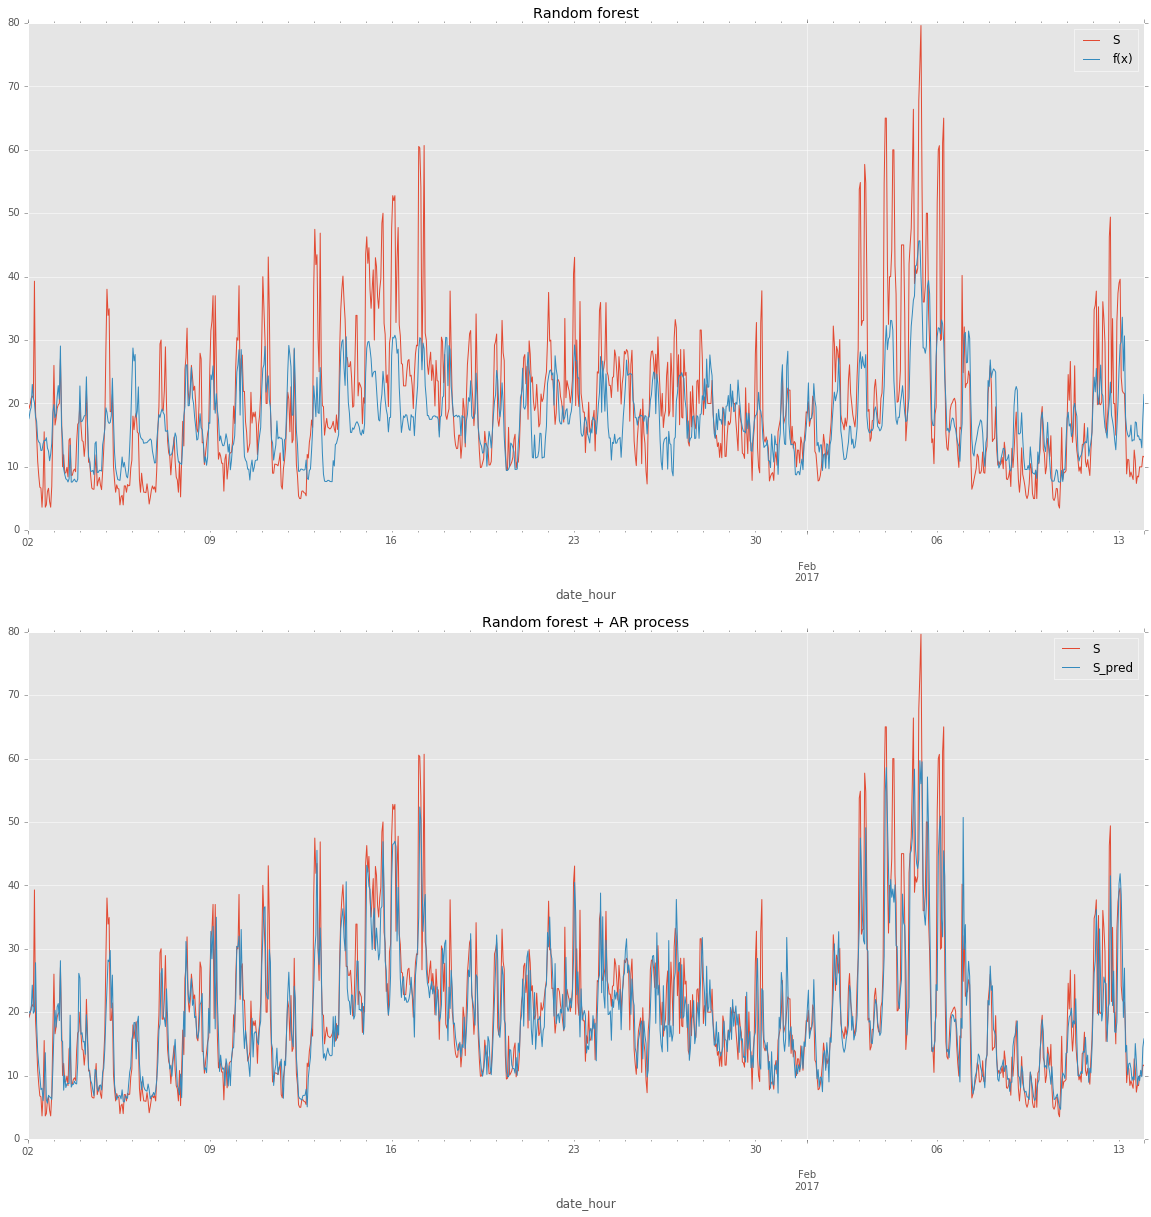

In [36]:
fig, (ax0,ax1) = plt.subplots(2,1, figsize=(20,20))
rf_arima_df[['S', 'f(x)']].plot(ax=ax0)
ax0.set_title('Random forest')
rf_arima_df[['S','S_pred']].plot(ax=ax1)
ax1.set_title('Random forest + AR process');

In [37]:
#Compute error
print('MAE: %.4f, MSE: %.4f' %(mean_absolute_error(rf_arima_df.dropna()['S'], rf_arima_df.dropna()['S_pred']), 
                               mean_squared_error(rf_arima_df.dropna()['S'], rf_arima_df.dropna()['S_pred'])))

MAE: 3.9348, MSE: 34.6645


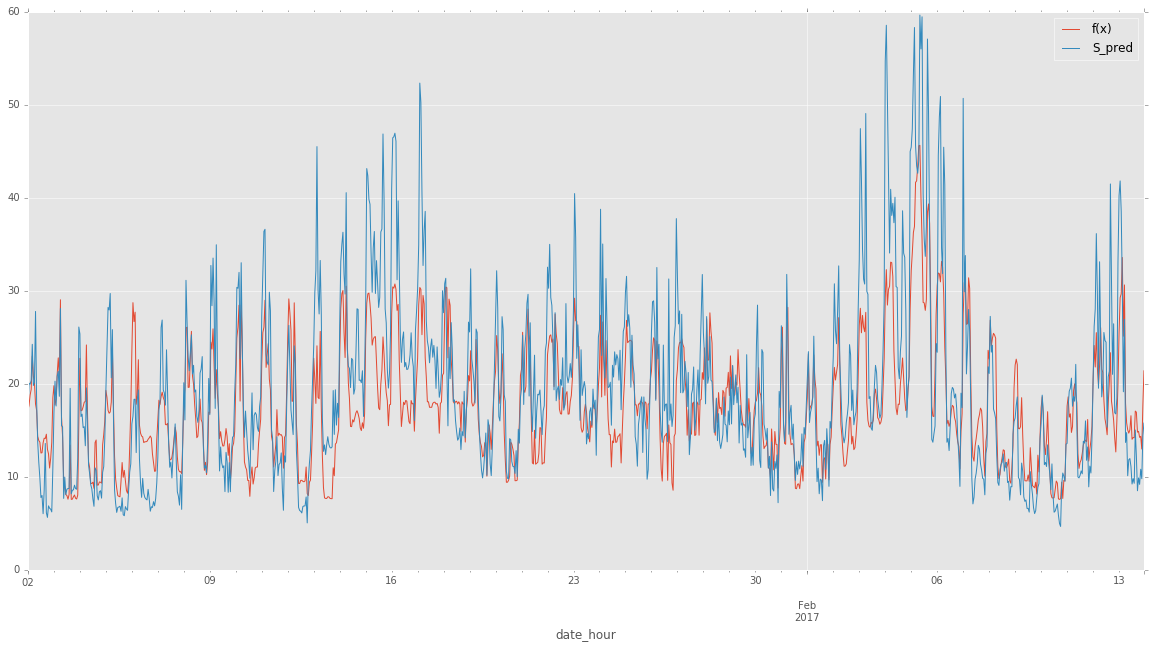

In [38]:
#Plot differences between RF and RF+AR
rf_arima_df[['f(x)','S_pred']].dropna().plot(figsize=(20,10));

In [39]:
#Adding white noise N(0, sigma_x
np.random.seed(0)
noise = np.random.normal(loc=0, scale=std_innovations, size=(len(Y)))

In [40]:
noise_df = pd.DataFrame(data=noise, index=rf_arima_df.index, columns=['noise'])

In [41]:
rf_ar_noise_df = rf_arima_df.merge(noise_df, how='left', left_index=True, right_index=True)

In [42]:
rf_ar_noise_df['S_pred_noise'] = rf_ar_noise_df['f(x)']*np.exp(rf_ar_noise_df['zt_pred'] + rf_ar_noise_df['noise'])

In [43]:
print('MAE: %.4f, MSE: %.4f' %(mean_absolute_error(rf_ar_noise_df.dropna()['S'], rf_ar_noise_df.dropna()['S_pred_noise']), 
                               mean_squared_error(rf_ar_noise_df.dropna()['S'], rf_ar_noise_df.dropna()['S_pred_noise'])))

MAE: 5.2618, MSE: 57.3918


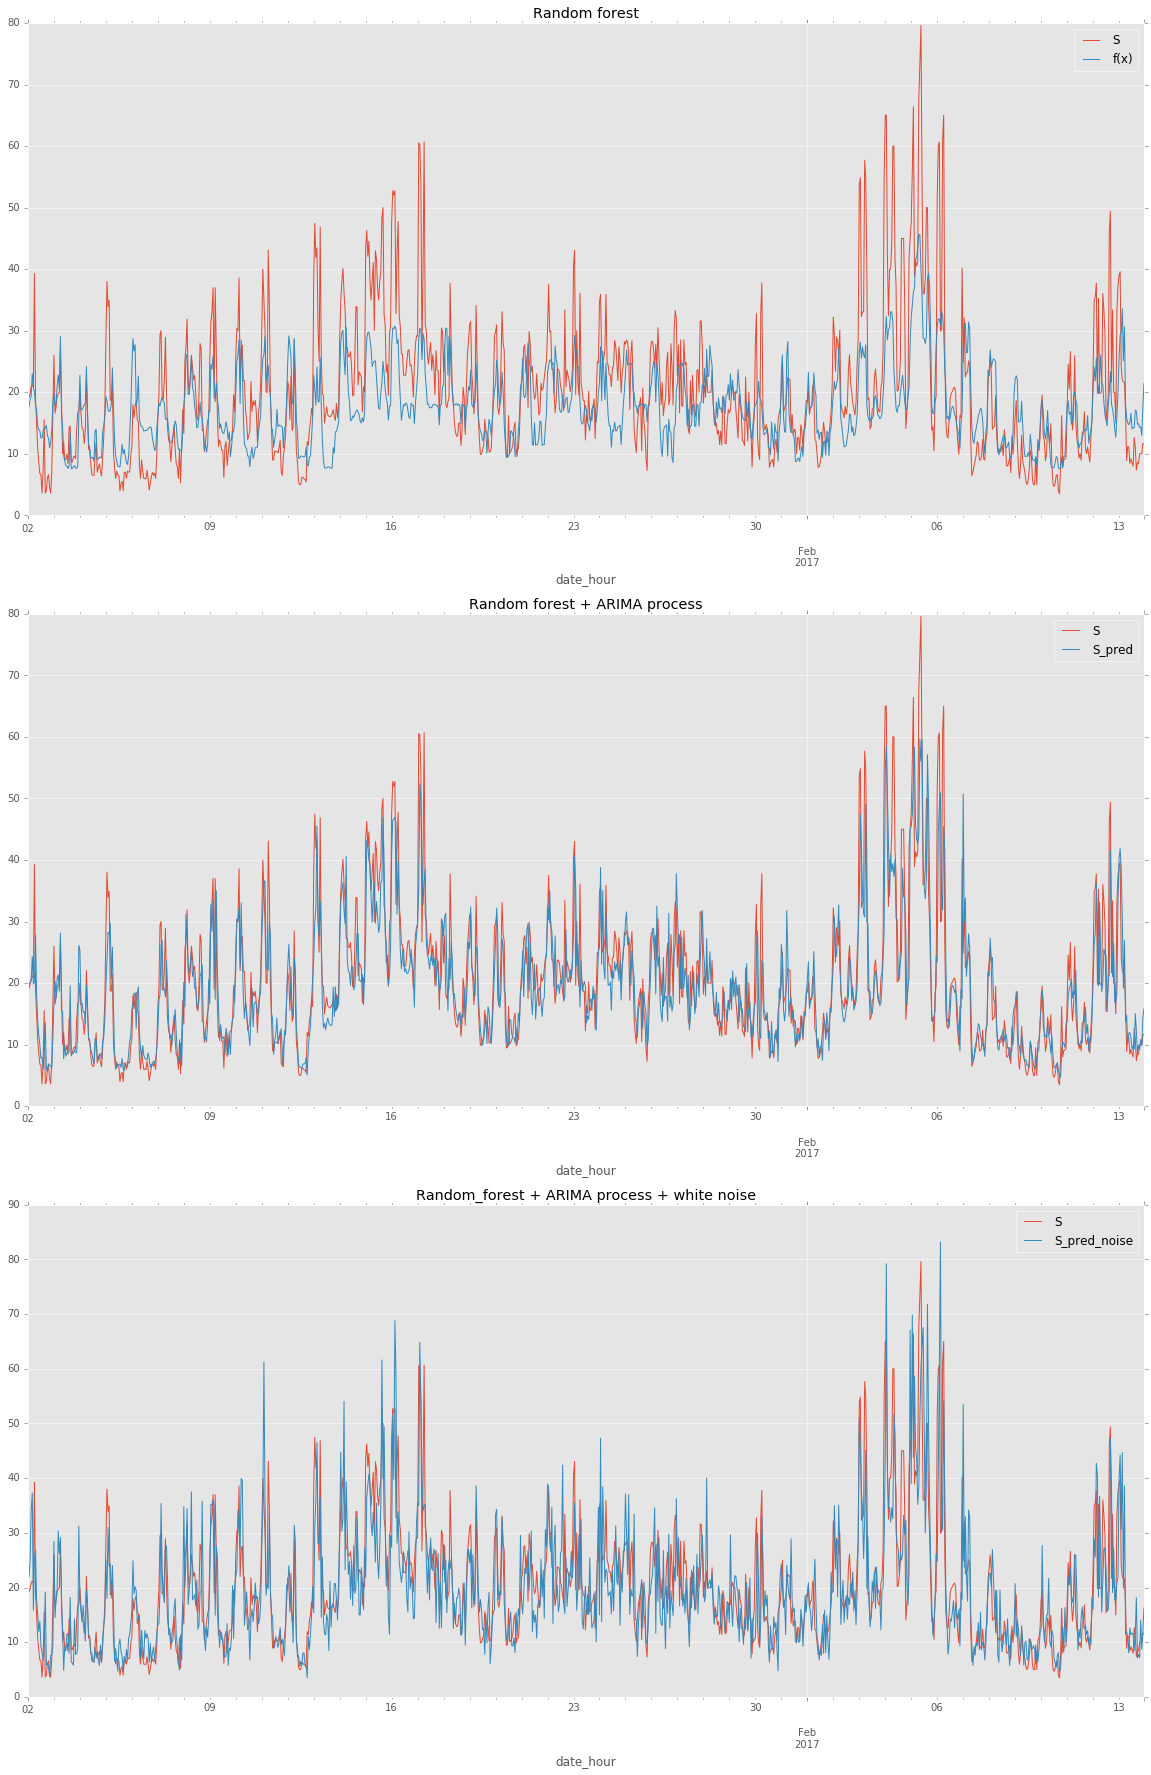

In [44]:
fig, (ax0,ax1,ax2) = plt.subplots(3,1, figsize=(20,30))
rf_ar_noise_df[['S', 'f(x)']].plot(ax=ax0)
ax0.set_title('Random forest')
rf_ar_noise_df[['S', 'S_pred']].plot(ax=ax1)
ax1.set_title('Random forest + ARIMA process')
rf_ar_noise_df[['S', 'S_pred_noise']].plot(ax=ax2)
ax2.set_title('Random_forest + ARIMA process + white noise');

### Generate a Monte Carlo simulation for one day
*Selected day: 5-Feb*

In [ ]:
np.random.seed(0)

In [ ]:
def gen_sn(M, I, std):
    """
    Function that generates random numbers, matching first moment, i.e. mean 0
    M: Length of the simulation process
    I: Number of paths to be simulated
    std: Standard deviation of the desired normal random numbers
    """
    sn = np.random.normal(loc=0, scale=std, size=(M, I/2))
    sn = np.concatenate((sn, -sn), axis=1)
    return sn

In [ ]:
#Create errors array, 24 hours, 10000 simulations
errors_mc = gen_sn(24, 10000, std_innovations)

In [ ]:
#Get index of desired day, plot real values and predicted from random forest
first_index = np.flatnonzero(residuals_df.index =='2017-02-05 00:00:00')[0]
residuals_df.iloc[first_index:first_index+24][['y_true', 'y_pred']].plot(figsize=(8,4))
fx_mc = residuals_df.iloc[first_index:first_index+24]['y_pred'].values

In [ ]:
#Get residuals
residuals_5_feb = (np.log1p(residuals_df.iloc[first_index-3:first_index+24]['y_true']) - 
                  np.log1p(residuals_df.iloc[first_index-3:first_index+24]['y_pred'])).values

#Generate xt function
xt = np.zeros(len(residuals_5_feb)-3)
for t in range(0, len(residuals_5_feb)-3):
    xt[t] = compute_ar(ar_param, residuals_5_feb[t:t+3])

In [ ]:
results = pd.DataFrame(data=(fx_mc.shape * np.exp(np.array([xt]).T + errors_mc)))
real_band_pred_5_feb = residuals_df.iloc[first_index:first_index+24].reset_index()[['y_true', 'y_pred']]

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
results.iloc[:,:1000].plot(ax=ax, alpha=0.3, legend=False)
results.iloc[:,:1000].mean(axis=1).rename('mean').plot(lw=2.0, ls='--', legend=True, color='black', ax=ax)
real_band_pred_5_feb.plot(lw=2.0, ls='-', ax=ax);